# Nevus segmentation

---

## About the dataset

The images have been taken from [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html). These are photographs of two types of **skin lesions:** melanoma and moles. They will not be classifieed, but segmented.
Here is the example of the original image and its segmentation:

<table><tr><td>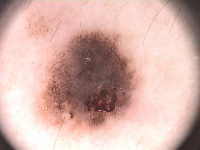</td><td>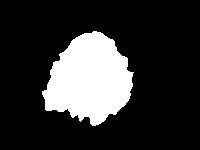</td></tr></table>

## Libraries

In [1]:
#!pip install googledrivedownloader
#!pip install patool

In [2]:
# Dowloading folder with images
from google_drive_downloader import GoogleDriveDownloader as gdd
import patoolib
import os

# Working with images
from skimage.io import imread, imshow
from skimage.transform import resize

# Plotting
from matplotlib import pyplot as plt
from matplotlib import rcParams
from IPython import display

# Working with arrays
import numpy as np

# PyTorch
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

## 1. Data preparation

### Downloading and unraring data

In [3]:
# Downloading data from Google drive
gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [4]:
# Extraction from archive
patoolib.extract_archive("PH2Dataset.rar")

patool: Extracting PH2Dataset.rar ...
patool: running /usr/bin/unrar x -- /content/PH2Dataset.rar
patool:     with cwd='./Unpack_n0krlfdo'
patool: ... PH2Dataset.rar extracted to `PH2Dataset1' (local file exists).


'PH2Dataset1'

Dataset structure:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

`X.bmp` — original image for segmentation, `X_lesion.bmp` — segmentation result.

Original and segmentated images from folder are extracted and added do images and lesions lists.

In [3]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

The first image and its segmentation.

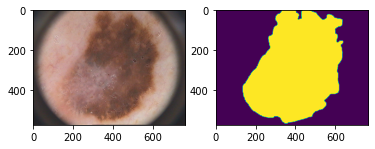

In [4]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(images[0])
ax[1].imshow(lesions[0])
plt.show()

### Data transformation

Images have different sizes. Let's resize them to $256\times256$ pixels. This function also automatically normalizes images in the $[0,1]$ range.

In [5]:
size = (256, 256)

# It is crucial to useGaussian filter when resizing the image to avoid aliasing artifacts.
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Checking if everything is correct.

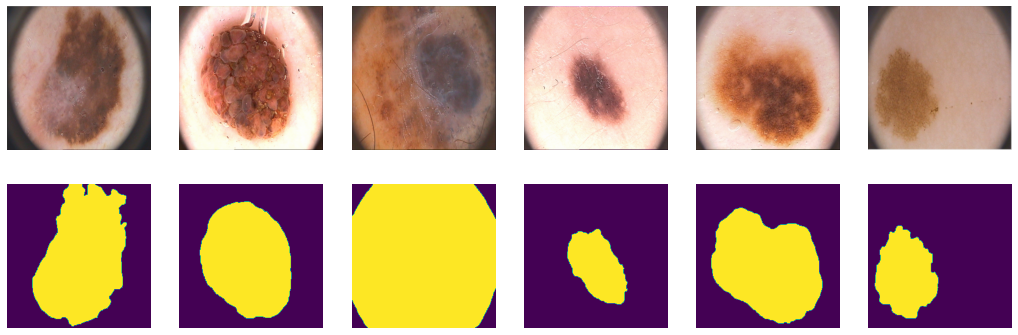

In [7]:
plt.figure(figsize=(18, 6))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Our 200 images will be divided into train, validation and test in the proportion of 100/50/50.

In [7]:
ix = np.random.choice(len(X), size=len(X), replace=False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


### Loading data in PyTorch DataLoader

In [9]:
batch_size = 25

# np.rollaxis - Roll the specified axis backwards, until it lies in a given position. From (100, 256, 256, 3) --> (100, 3, 256, 256).
# np.newaxis - Increase the dimension of the existing array by one. From (100, 256, 256) --> (100, 1, 256, 256).


data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, start=1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, start=1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, start=1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 2. Different architectures

Several neural network architectures will be tested for semantic segmentation problem. They are compared in terms of quality on the test and with different loss functions for them.

-----------------------------------------------------------------------------------------

### a) SegNet

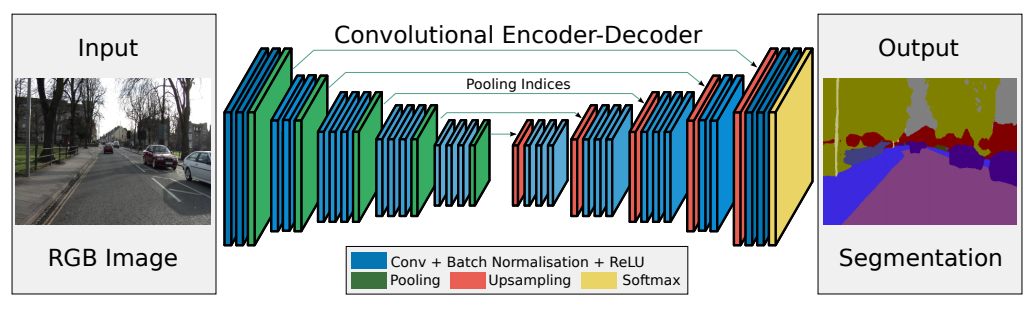

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

**Simple deconvolution network.**

In [11]:
# All rc (runtime config) settings are stored in a dictionary-like variable called matplotlib.rcParams, which is global to the matplotlib package.
rcParams['figure.figsize'] = (15,4)

In [12]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        # out_channels - number of filters
        # in_channels - Number of channels in the input image
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        # self.bottleneck_conv = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()            
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()   
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()   
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()   
        )

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        # b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(e3, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0))  # no activation

        return d3

### Metrics

The first one can be Jaccard similarity:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [25]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2)) 
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10 
    
    return thresholded 

### Loss function

Binary cross-entropy can be used:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

, but $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability in the optimization process.Thus, modification is used.

In [24]:
def bce_loss(y_real, y_pred):
    # y_pred - logits
    # y_real - labels
    zeros = torch.zeros(size=y_pred.shape).to(device)
    loss = torch.mean(torch.max(y_pred, zeros) - y_pred * y_real + torch.log(1 + torch.exp(-abs(y_pred))))
    return loss

### Training cycle

In [15]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, visual=False):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0

        # train mode
        model.train()
        
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch=X_batch.to(device)
            Y_batch=Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            # loss
            loss = loss_fn(Y_batch,Y_pred) 
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(Y_batch)
            
        print('Average train loss: %f' % avg_loss)

        # testing mode
        model.eval()  
        logits = model(X_val.to(device))
        probabilities = torch.sigmoid(logits)
        preds = (probabilities>0.5).type(torch.long)
        Y_hat = preds.cpu().detach()
        
        # Visualize tools
        if visual:
            display.clear_output(wait=True)
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(2, 6, k+7)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')
            plt.show()

### Testing on new data with Jaccard similarity

In [23]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        probs = torch.sigmoid(Y_pred.cpu().detach())
        preds = (probs>0.5).type(torch.long)
        scores += metric(preds, Y_label).mean().item()

    return scores/len(data)

### Training on the data

In [17]:
model = SegNet().to(device)

In [18]:
max_epochs = 20
optim = torch.optim.Adam(model.parameters())
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

* Epoch 1/20
Average train loss: 0.115506
* Epoch 2/20
Average train loss: 0.109526
* Epoch 3/20
Average train loss: 0.108598
* Epoch 4/20
Average train loss: 0.108006
* Epoch 5/20
Average train loss: 0.106769
* Epoch 6/20
Average train loss: 0.105456
* Epoch 7/20
Average train loss: 0.104183
* Epoch 8/20
Average train loss: 0.103471
* Epoch 9/20
Average train loss: 0.102257
* Epoch 10/20
Average train loss: 0.102229
* Epoch 11/20
Average train loss: 0.102001
* Epoch 12/20
Average train loss: 0.101546
* Epoch 13/20
Average train loss: 0.102437
* Epoch 14/20
Average train loss: 0.102204
* Epoch 15/20
Average train loss: 0.101658
* Epoch 16/20
Average train loss: 0.101143
* Epoch 17/20
Average train loss: 0.101694
* Epoch 18/20
Average train loss: 0.101038
* Epoch 19/20
Average train loss: 0.100493
* Epoch 20/20
Average train loss: 0.100754
